## No 1

### Inisiasi awal

In [ ]:
!pip install pyspark
# Load dataset
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1583kSe2k2sKAK5mcx6oghhHvFW37Q8xD' -O liver_disease_dataset.csv

--2024-01-01 12:00:58--  https://drive.google.com/uc?export=download&id=1S70liyqXmO5cyS9GXhJJPer6KSJxHMIx
Resolving drive.google.com (drive.google.com)... 173.194.212.101, 173.194.212.139, 173.194.212.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.212.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qcf1lflqla1jf6ckj9fa0pr5mha14uur/1704110400000/17413099561548057696/*/1S70liyqXmO5cyS9GXhJJPer6KSJxHMIx?e=download&uuid=8c6ff251-1052-438d-9055-c8f7b0cfa7f9 [following]
--2024-01-01 12:00:59--  https://doc-0k-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qcf1lflqla1jf6ckj9fa0pr5mha14uur/1704110400000/17413099561548057696/*/1S70liyqXmO5cyS9GXhJJPer6KSJxHMIx?e=download&uuid=8c6ff251-1052-438d-9055-c8f7b0cfa7f9
Resolving doc-0k-1k-docs.googleusercontent.com (doc-0k-1k-docs.googleusercontent.com)... 173.194.210.132, 

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, monotonically_increasing_id
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import when
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import Row
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier






In [ ]:
# Inisialisasi Spark Session
spark = SparkSession.builder.appName("LiverDiseaseClassification").getOrCreate()

In [ ]:
# Load dataset
dataset_path = "liver_disease_dataset.csv"
df = spark.read.csv(dataset_path, header=True, inferSchema=True)

###Data Preprosest

In [ ]:
df.show()

+---+------+------+---------------+-----+---+-------+------------+-------+-----+---------+-----------+-------+------+--------+------+-------------+---------+-----------+-----+
| ID|N_Days|Status|           Drug|  Age|Sex|Ascites|Hepatomegaly|Spiders|Edema|Bilirubin|Cholesterol|Albumin|Copper|Alk_Phos|  SGOT|Tryglicerides|Platelets|Prothrombin|Stage|
+---+------+------+---------------+-----+---+-------+------------+-------+-----+---------+-----------+-------+------+--------+------+-------------+---------+-----------+-----+
|  1|   400|     D|D-penicillamine|21464|  F|      Y|           Y|      Y|    Y|     14.5|        261|    2.6|   156|    1718|137.95|          172|      190|       12.2|    4|
|  2|  4500|     C|D-penicillamine|20617|  F|      N|           Y|      Y|    N|      1.1|        302|   4.14|    54|  7394.8|113.52|           88|      221|       10.6|    3|
|  3|  1012|     D|D-penicillamine|25594|  M|      N|           N|      N|    S|      1.4|        176|   3.48|   210|   

In [ ]:
# Melihat nilai unik di setiap kolom
for col_name in df.columns:
    unique_values = df.select(col_name).distinct().collect()
    unique_values_list = [val[col_name] for val in unique_values]
    print(f"Unique values in {col_name}: {unique_values_list}")

Unique values in ID: [148, 243, 392, 31, 85, 137, 251, 65, 53, 255, 133, 296, 78, 322, 321, 362, 375, 108, 155, 34, 193, 211, 368, 101, 115, 126, 81, 385, 28, 183, 210, 300, 406, 412, 76, 26, 27, 332, 384, 44, 159, 192, 271, 253, 103, 236, 329, 12, 336, 350, 223, 388, 417, 91, 409, 333, 222, 285, 22, 128, 209, 330, 372, 122, 230, 319, 93, 157, 190, 225, 232, 233, 246, 346, 360, 367, 111, 224, 47, 140, 177, 416, 132, 152, 185, 305, 353, 355, 291, 325, 386, 146, 259, 1, 206, 52, 297, 363, 212, 274, 182, 13, 218, 280, 348, 6, 16, 86, 168, 205, 3, 142, 178, 308, 328, 20, 40, 164, 169, 139, 283, 359, 295, 340, 94, 250, 377, 402, 57, 292, 306, 339, 54, 120, 96, 235, 48, 266, 5, 163, 191, 268, 258, 279, 19, 397, 92, 415, 257, 299, 64, 117, 227, 41, 154, 309, 347, 15, 43, 262, 112, 269, 327, 165, 358, 366, 179, 189, 207, 37, 383, 61, 127, 316, 88, 197, 318, 107, 202, 263, 374, 9, 17, 231, 324, 72, 286, 398, 175, 387, 381, 35, 310, 196, 217, 290, 229, 307, 326, 114, 173, 220, 278, 301, 4, 55, 5

In [ ]:
# Menghapus baris dengan nilai 'NA' di salah satu kolom
df = df.replace('NA', None)
df = df.na.drop()

# Menyusun ulang indeks DataFrame
df = df.withColumn("index", monotonically_increasing_id())
df = df.select("*").orderBy("index").drop("index")

In [ ]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- N_Days: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Drug: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Ascites: string (nullable = true)
 |-- Hepatomegaly: string (nullable = true)
 |-- Spiders: string (nullable = true)
 |-- Edema: string (nullable = true)
 |-- Bilirubin: double (nullable = true)
 |-- Cholesterol: string (nullable = true)
 |-- Albumin: double (nullable = true)
 |-- Copper: string (nullable = true)
 |-- Alk_Phos: string (nullable = true)
 |-- SGOT: string (nullable = true)
 |-- Tryglicerides: string (nullable = true)
 |-- Platelets: string (nullable = true)
 |-- Prothrombin: string (nullable = true)
 |-- Stage: string (nullable = true)



In [ ]:
# Mapping
df = df.withColumn("Status", when(df["Status"] == 'CL', 0).when(df["Status"] == 'D', 1).when(df["Status"] == 'C', 2))
df = df.withColumn("Drug", when(df["Drug"] == 'Placebo', 0).when(df["Drug"] == 'D-penicillamine', 1))
df = df.withColumn("Sex", when(df["Sex"] == 'F', 0).when(df["Sex"] == 'M', 1))
df = df.withColumn("Ascites", when(df["Ascites"] == 'N', 0).when(df["Ascites"] == 'Y', 1))
df = df.withColumn("Hepatomegaly", when(df["Hepatomegaly"] == 'N', 0).when(df["Hepatomegaly"] == 'Y', 1))
df = df.withColumn("Spiders", when(df["Spiders"] == 'N', 0).when(df["Spiders"] == 'Y', 1))
df = df.withColumn("Edema", when(df["Edema"] == 'Y', 0).when(df["Edema"] == 'N', 1).when(df["Edema"] == 'S', 2))

# Konversi tipe data
df = df.withColumn("Cholesterol", df["Cholesterol"].cast(DoubleType()))
df = df.withColumn("Copper", df["Copper"].cast(DoubleType()))
df = df.withColumn("Alk_Phos", df["Alk_Phos"].cast(DoubleType()))
df = df.withColumn("SGOT", df["SGOT"].cast(DoubleType()))
df = df.withColumn("Tryglicerides", df["Tryglicerides"].cast(DoubleType()))
df = df.withColumn("Platelets", df["Platelets"].cast(DoubleType()))
df = df.withColumn("Prothrombin", df["Prothrombin"].cast(DoubleType()))
df = df.withColumn("Stage", df["Stage"].cast(DoubleType()))
df = df.withColumn("Stage", df["Stage"].cast(IntegerType()))
# Cetak schema setelah perubahan
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- N_Days: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Drug: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- Ascites: integer (nullable = true)
 |-- Hepatomegaly: integer (nullable = true)
 |-- Spiders: integer (nullable = true)
 |-- Edema: integer (nullable = true)
 |-- Bilirubin: double (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- Albumin: double (nullable = true)
 |-- Copper: double (nullable = true)
 |-- Alk_Phos: double (nullable = true)
 |-- SGOT: double (nullable = true)
 |-- Tryglicerides: double (nullable = true)
 |-- Platelets: double (nullable = true)
 |-- Prothrombin: double (nullable = true)
 |-- Stage: integer (nullable = true)



In [ ]:
df.show()

+---+------+------+----+-----+---+-------+------------+-------+-----+---------+-----------+-------+------+--------+------+-------------+---------+-----------+-----+
| ID|N_Days|Status|Drug|  Age|Sex|Ascites|Hepatomegaly|Spiders|Edema|Bilirubin|Cholesterol|Albumin|Copper|Alk_Phos|  SGOT|Tryglicerides|Platelets|Prothrombin|Stage|
+---+------+------+----+-----+---+-------+------------+-------+-----+---------+-----------+-------+------+--------+------+-------------+---------+-----------+-----+
|  1|   400|     1|   1|21464|  0|      1|           1|      1|    0|     14.5|      261.0|    2.6| 156.0|  1718.0|137.95|        172.0|    190.0|       12.2|    4|
|  2|  4500|     2|   1|20617|  0|      0|           1|      1|    1|      1.1|      302.0|   4.14|  54.0|  7394.8|113.52|         88.0|    221.0|       10.6|    3|
|  3|  1012|     1|   1|25594|  1|      0|           0|      0|    2|      1.4|      176.0|   3.48| 210.0|   516.0|  96.1|         55.0|    151.0|       12.0|    4|
|  4|  192

###Analisis awal

In [ ]:
# Menampilkan summary statistics
summary_stats = df.describe().toPandas()
print(summary_stats)

  summary                 ID              N_Days              Status  \
0   count                276                 276                 276   
1    mean  158.6159420289855  1979.1666666666667  1.4673913043478262   
2  stddev  91.66292578305227  1112.3802952282651  0.6170502314579362   
3     min                  1                  41                   0   
4     max                312                4556                   2   

                 Drug                Age                  Sex  \
0                 276                276                  276   
1  0.4927536231884058  18189.32608695652  0.12318840579710146   
2  0.5008556578364917   3843.55561931074   0.3292503562662449   
3                   0               9598                    0   
4                   1              28650                    1   

               Ascites        Hepatomegaly             Spiders  ...  \
0                  276                 276                 276  ...   
1  0.06884057971014493  0.51449275

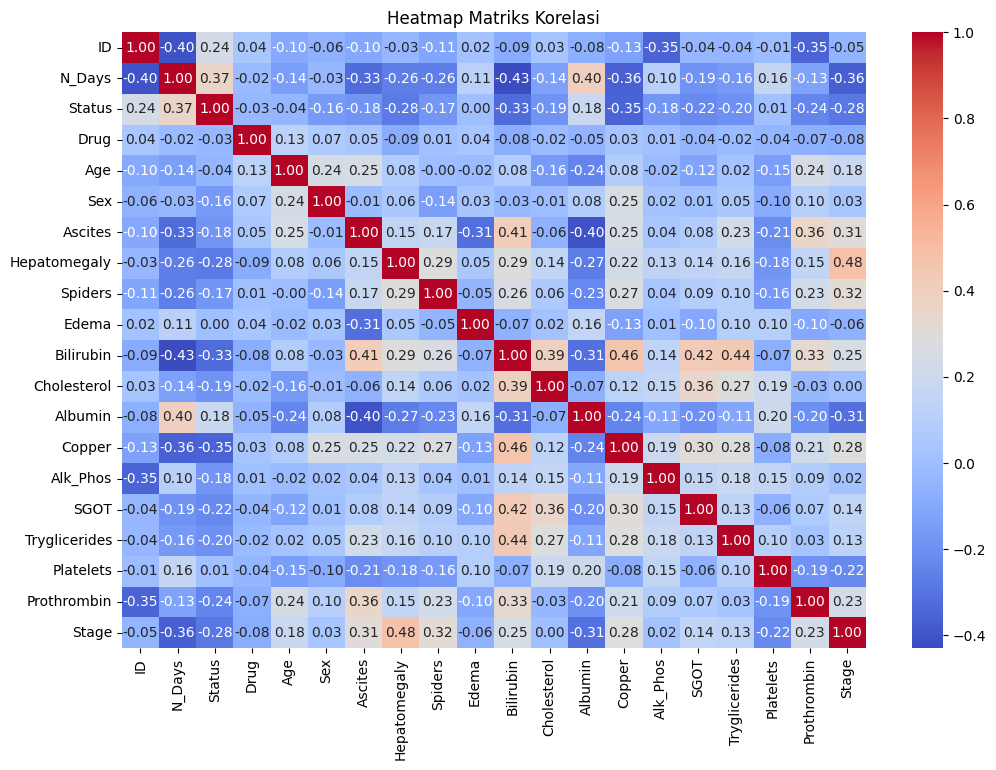

In [ ]:
# Memilih kolom numerik
numeric_cols = [col_name for col_name, data_type in df.dtypes if data_type in ['int', 'double']]
# Menggabungkan kolom-kolom numerik menjadi satu vektor kolom
vector_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_assembled = vector_assembler.transform(df)
# Menghitung matriks korelasi
correlation_matrix = Correlation.corr(df_assembled, "features").head()
# Matriks korelasi sebagai array
corr_array = correlation_matrix[0].toArray()
# Membuat DataFrame dari array korelasi
corr_df = pd.DataFrame(corr_array, columns=numeric_cols, index=numeric_cols)

# Membuat heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap Matriks Korelasi")
plt.show()

#No 2

##Modelling

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Definisi fitur dan target
features = ['Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
target = 'Stage'

# Menggunakan VectorAssembler untuk menggabungkan fitur ke dalam vektor
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)

# Memilih kolom yang dibutuhkan
df = df.select("features", target)

## Decision Tree

In [ ]:

# Membagi data menjadi set pelatihan dan uji (80% pelatihan, 20% pengujian)
train_data, test_data = df.randomSplit([0.9, 0.1], seed=123)
# Membuat model Decision Tree
dt = DecisionTreeClassifier(labelCol=target, featuresCol="features")
# Membuat pipeline
pipeline_dt = Pipeline(stages=[dt])
# Melatih model
model_dt = pipeline_dt.fit(train_data)
# Melakukan prediksi pada data pengujian
predictions_dt = model_dt.transform(test_data)
# Mengevaluasi model Decision Tree
evaluator_dt = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction")
accuracy_dt = evaluator_dt.evaluate(predictions_dt, {evaluator_dt.metricName: "accuracy"})
f1_score_dt = evaluator_dt.evaluate(predictions_dt, {evaluator_dt.metricName: "f1"})
precision_dt = evaluator_dt.evaluate(predictions_dt, {evaluator_dt.metricName: "weightedPrecision"})
recall_dt = evaluator_dt.evaluate(predictions_dt, {evaluator_dt.metricName: "weightedRecall"})

# Menampilkan hasil perbandingan
print("\nDecision Tree Metrics:")
print(f"Akurasi: {accuracy_dt}")
print(f"F1 Score: {f1_score_dt}")
print(f"Presisi: {precision_dt}")
print(f"Recall: {recall_dt}")


Decision Tree Metrics:
Akurasi: 0.47619047619047616
F1 Score: 0.47907647907647904
Presisi: 0.49047619047619045
Recall: 0.47619047619047616


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Inisialisasi Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol=target, featuresCol="features")

# Membuat pipeline
pipeline_dt = Pipeline(stages=[dt])

# Membuat grid parameter untuk Decision Tree
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [20, 40, 60]) \
    .build()
# Mengevaluasi model Decision Tree
evaluator = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction", metricName="accuracy")

# Inisialisasi CrossValidator
crossval_dt = CrossValidator(estimator=pipeline_dt,
                             estimatorParamMaps=paramGrid_dt,
                             evaluator=MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction", metricName="accuracy"),
                             numFolds=3)  # Jumlah lipatan validasi silang

# Melatih model Decision Tree dengan hyperparameter tuning
cvModel_dt = crossval_dt.fit(train_data)

# Mendapatkan model terbaik
best_model_dt = cvModel_dt.bestModel

# Melakukan prediksi pada data pengujian
predictions_dt = best_model_dt.transform(test_data)

# Mengukur performa model pada data pengujian
accuracy_dtt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "accuracy"})
precision_dtt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "weightedPrecision"})
recall_dtt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "weightedRecall"})
f1_score_dtt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "f1"})

print("Decision Tree Metrics:")
print(f"Accuracy: {accuracy_dtt}")
print(f"Precision: {precision_dtt}")
print(f"Recall: {recall_dtt}")
print(f"F1 Score: {f1_score_dtt}")

Decision Tree Metrics:
Accuracy: 0.38095238095238093
Precision: 0.4126984126984126
Recall: 0.38095238095238093
F1 Score: 0.3958198664081017


## Random Frorest

In [ ]:

# Membagi data menjadi set pelatihan dan uji (80% pelatihan, 20% pengujian)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)
# Membuat model Random Forest
rf = RandomForestClassifier(labelCol=target, featuresCol="features")
# Membuat pipeline
pipeline_rf = Pipeline(stages=[rf])
# Melatih model
model_rf = pipeline_rf.fit(train_data)
# Melakukan prediksi pada data pengujian
predictions_rf = model_rf.transform(test_data)
# Mengevaluasi model Random Forest
evaluator_rf = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction")
accuracy_rf = evaluator_rf.evaluate(predictions_rf, {evaluator_rf.metricName: "accuracy"})
f1_score_rf = evaluator_rf.evaluate(predictions_rf, {evaluator_rf.metricName: "f1"})
precision_rf = evaluator_rf.evaluate(predictions_rf, {evaluator_rf.metricName: "weightedPrecision"})
recall_rf = evaluator_rf.evaluate(predictions_rf, {evaluator_rf.metricName: "weightedRecall"})


print("\nRandom Forest Metrics:")
print(f"Akurasi: {accuracy_rf}")
print(f"F1 Score: {f1_score_rf}")
print(f"Presisi: {precision_rf}")
print(f"Recall: {recall_rf}")



Random Forest Metrics:
Akurasi: 0.5689655172413793
F1 Score: 0.5620720498426994
Presisi: 0.5581709145427287
Recall: 0.5689655172413793


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Inisialisasi Random Forest Classifier
rf = RandomForestClassifier(labelCol=target, featuresCol="features")

# Membuat pipeline
pipeline_rf = Pipeline(stages=[rf])

# Membuat grid parameter untuk Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .build()

# Inisialisasi CrossValidator
crossval_rf = CrossValidator(estimator=pipeline_rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction", metricName="accuracy"),
                             numFolds=3)  # Jumlah lipatan validasi silang

# Melatih model Random Forest dengan hyperparameter tuning
cvModel_rf = crossval_rf.fit(train_data)

# Mendapatkan model terbaik
best_model_rf = cvModel_rf.bestModel

# Melakukan prediksi pada data pengujian
predictions_rf = best_model_rf.transform(test_data)


# Mengukur performa model pada data pengujian
accuracy_rft = evaluator.evaluate(predictions_rf, {evaluator.metricName: "accuracy"})
precision_rft = evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"})
recall_rft = evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"})
f1_score_rft = evaluator.evaluate(predictions_rf, {evaluator.metricName: "f1"})

print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_rft}")
print(f"Precision: {precision_rft}")
print(f"Recall: {recall_rft}")
print(f"F1 Score: {f1_score_rft}")


Random Forest Metrics:
Accuracy: 0.5689655172413793
Precision: 0.5581709145427287
Recall: 0.5689655172413793
F1 Score: 0.5620720498426994


## c

### boxplot distribusi

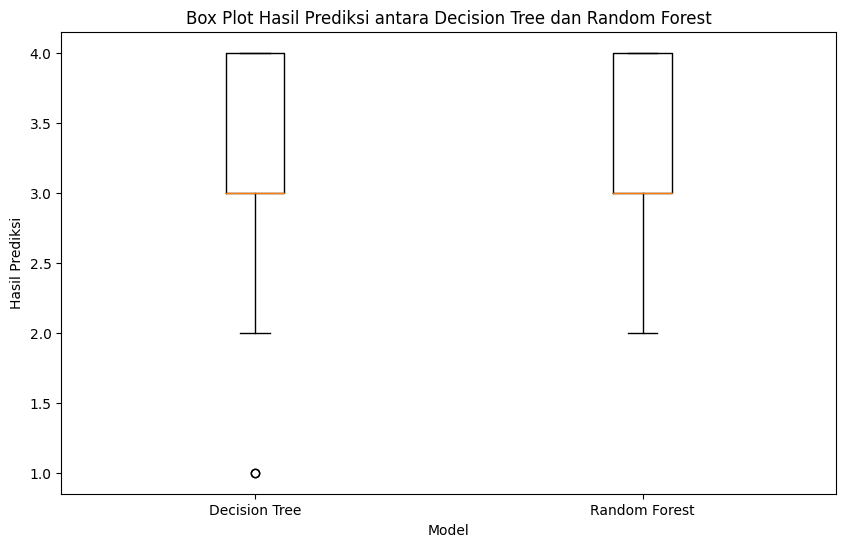

In [ ]:

# Hasil prediksi dari model Decision Tree
predictions_dt = model_dt.transform(test_data)
y_true_dt = predictions_dt.select("Stage").rdd.flatMap(lambda x: x).collect()
y_pred_dt = predictions_dt.select("prediction").rdd.flatMap(lambda x: x).collect()

# Hasil prediksi dari model Random Forest
predictions_rf = model_rf.transform(test_data)
y_true_rf = predictions_rf.select("Stage").rdd.flatMap(lambda x: x).collect()
y_pred_rf = predictions_rf.select("prediction").rdd.flatMap(lambda x: x).collect()

# Menampilkan box plot
plt.figure(figsize=(10, 6))
plt.boxplot([y_pred_dt, y_pred_rf], labels=["Decision Tree", "Random Forest"])
plt.title("Box Plot Hasil Prediksi antara Decision Tree dan Random Forest")
plt.xlabel("Model")
plt.ylabel("Hasil Prediksi")
plt.show()

In [ ]:
print("y_pred_rf : ", y_pred_rf)
print("y_pred_rf : ", y_pred_dt)

y_pred_rf :  [3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 3.0, 3.0, 3.0, 2.0, 3.0, 4.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 3.0, 2.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 2.0, 4.0, 4.0, 2.0, 3.0, 2.0, 4.0, 4.0, 4.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 2.0, 3.0, 2.0, 3.0, 4.0, 4.0]
y_pred_rf :  [4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 4.0, 4.0, 3.0, 4.0, 2.0, 1.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 2.0, 3.0, 4.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 2.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 2.0, 2.0, 4.0, 4.0, 2.0, 2.0, 1.0, 3.0, 4.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 2.0, 4.0, 2.0, 3.0, 3.0, 3.0]


# No 3

## Grafik dari Hasil prediksi

### Perbandingan Metrik Evaluasi antara Decision Tree dan Random Forest

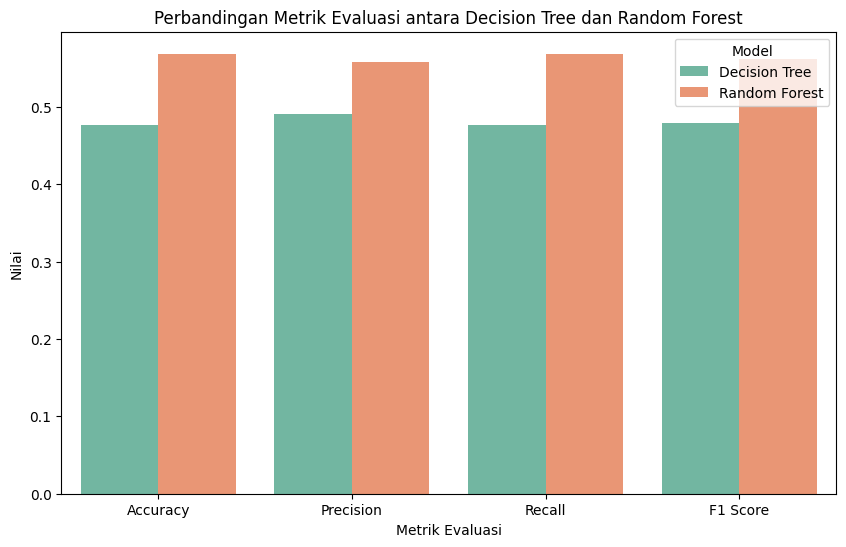

In [ ]:
# 2.c grafik box plot untuk masalah klasifikasi.
# Menampilkan bar plot
plt.figure(figsize=(10, 6))

# Membuat dataframe dari hasil evaluasi
df_metrics = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'Accuracy': [accuracy_dt, accuracy_rf],
    'Precision': [precision_dt, precision_rf],
    'Recall': [recall_dt, recall_rf],
    'F1 Score': [f1_score_dt, f1_score_rf]
})

# Melting dataframe untuk membuat bar plot
df_metrics_melted = pd.melt(df_metrics, id_vars='Model', var_name='Metric', value_name='Score')

# Menampilkan bar plot
sns.barplot(x='Metric', y='Score', hue='Model', data=df_metrics_melted, palette='Set2')
plt.title("Perbandingan Metrik Evaluasi antara Decision Tree dan Random Forest")
plt.xlabel("Metrik Evaluasi")
plt.ylabel("Nilai")
plt.legend(title="Model")
plt.show()

### Perbandingan Metrik Evaluasi antara Decision Tree dan Random Forest Hypertuning

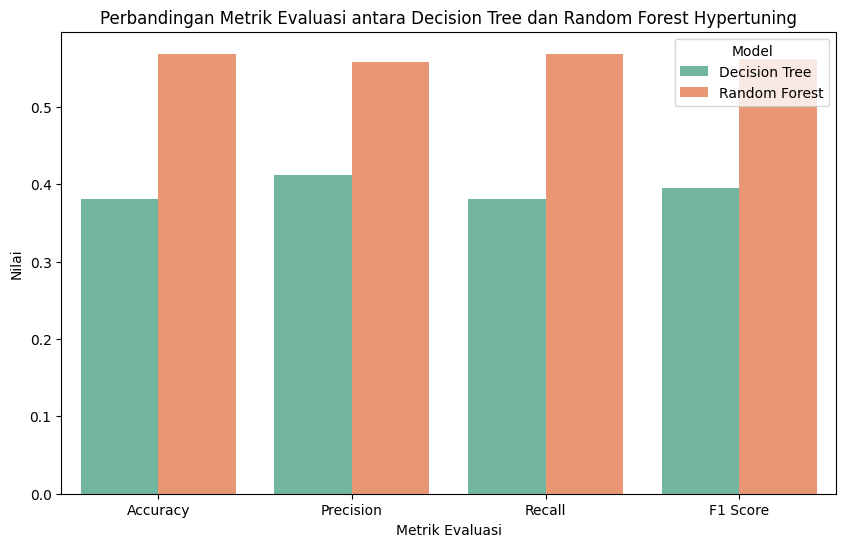

In [ ]:
# 2.c grafik box plot untuk masalah klasifikasi.
# Menampilkan bar plot
plt.figure(figsize=(10, 6))

# Membuat dataframe dari hasil evaluasi
df_metrics = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'Accuracy': [accuracy_dtt, accuracy_rft],
    'Precision': [precision_dtt, precision_rft],
    'Recall': [recall_dtt, recall_rft],
    'F1 Score': [f1_score_dtt, f1_score_rft]
})

# Melting dataframe untuk membuat bar plot
df_metrics_melted = pd.melt(df_metrics, id_vars='Model', var_name='Metric', value_name='Score')

# Menampilkan bar plot
sns.barplot(x='Metric', y='Score', hue='Model', data=df_metrics_melted, palette='Set2')
plt.title("Perbandingan Metrik Evaluasi antara Decision Tree dan Random Forest Hypertuning")
plt.xlabel("Metrik Evaluasi")
plt.ylabel("Nilai")
plt.legend(title="Model")
plt.show()

### Perbandingan Metrik Evaluasi Decision Tree Tuning dan normal

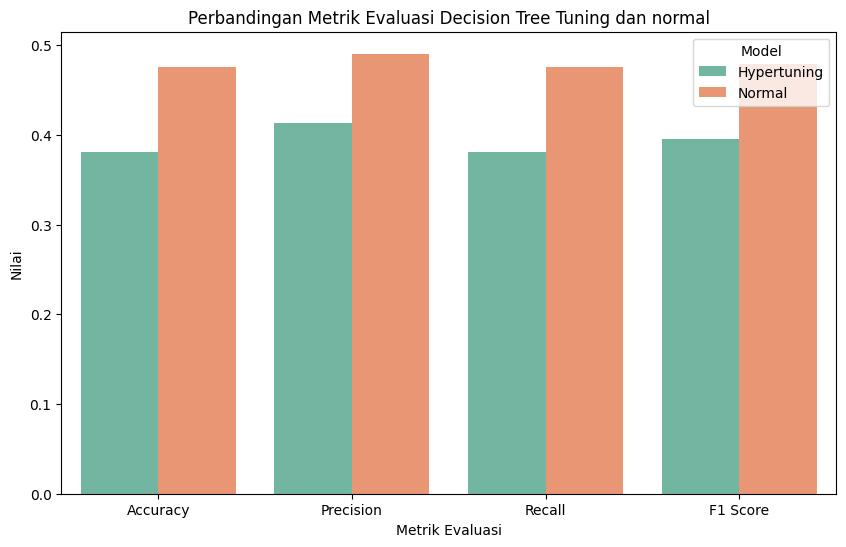

In [ ]:
# 2.c grafik box plot untuk masalah klasifikasi.
# Menampilkan bar plot
plt.figure(figsize=(10, 6))

# Membuat dataframe dari hasil evaluasi
df_metrics = pd.DataFrame({
    'Model': ['Hypertuning', 'Normal'],
    'Accuracy': [accuracy_dtt, accuracy_dt],
    'Precision': [precision_dtt, precision_dt],
    'Recall': [recall_dtt, recall_dt],
    'F1 Score': [f1_score_dtt, f1_score_dt]
})

# Melting dataframe untuk membuat bar plot
df_metrics_melted = pd.melt(df_metrics, id_vars='Model', var_name='Metric', value_name='Score')

# Menampilkan bar plot
sns.barplot(x='Metric', y='Score', hue='Model', data=df_metrics_melted, palette='Set2')
plt.title("Perbandingan Metrik Evaluasi Decision Tree Tuning dan normal")
plt.xlabel("Metrik Evaluasi")
plt.ylabel("Nilai")
plt.legend(title="Model")
plt.show()

### Perbandingan  Metrik Evaluasi Random Forest dengan Tuning dan Normal

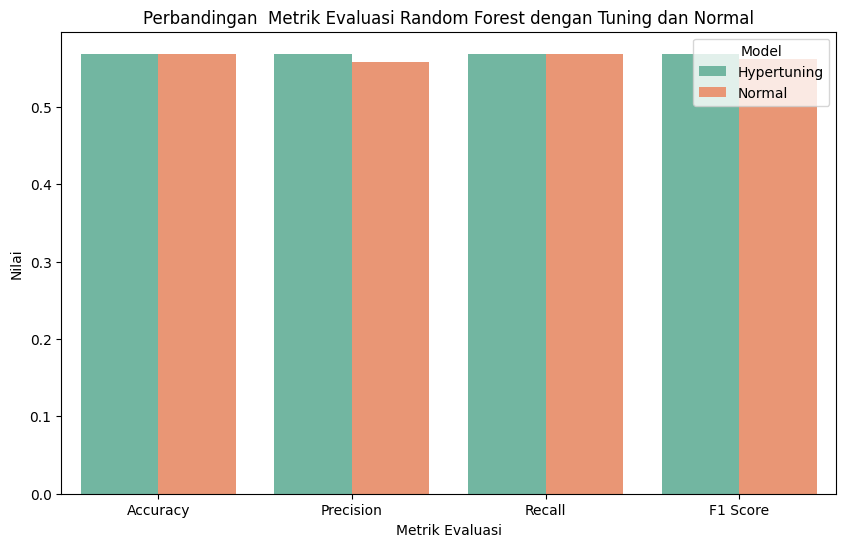

In [ ]:
# 2.c grafik box plot untuk masalah klasifikasi.
# Menampilkan bar plot
plt.figure(figsize=(10, 6))

# Membuat dataframe dari hasil evaluasi
df_metrics = pd.DataFrame({
    'Model': ['Hypertuning', 'Normal'],
    'Accuracy': [accuracy_rft, accuracy_rf],
    'Precision': [accuracy_rft, precision_rf],
    'Recall': [accuracy_rft, recall_rf],
    'F1 Score': [accuracy_rft, f1_score_rf]
})

# Melting dataframe untuk membuat bar plot
df_metrics_melted = pd.melt(df_metrics, id_vars='Model', var_name='Metric', value_name='Score')

# Menampilkan bar plot
sns.barplot(x='Metric', y='Score', hue='Model', data=df_metrics_melted, palette='Set2')
plt.title("Perbandingan  Metrik Evaluasi Random Forest dengan Tuning dan Normal")
plt.xlabel("Metrik Evaluasi")
plt.ylabel("Nilai")
plt.legend(title="Model")
plt.show()

In [ ]:
predictions_dt.printSchema()


root
 |-- features: vector (nullable = true)
 |-- Stage: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



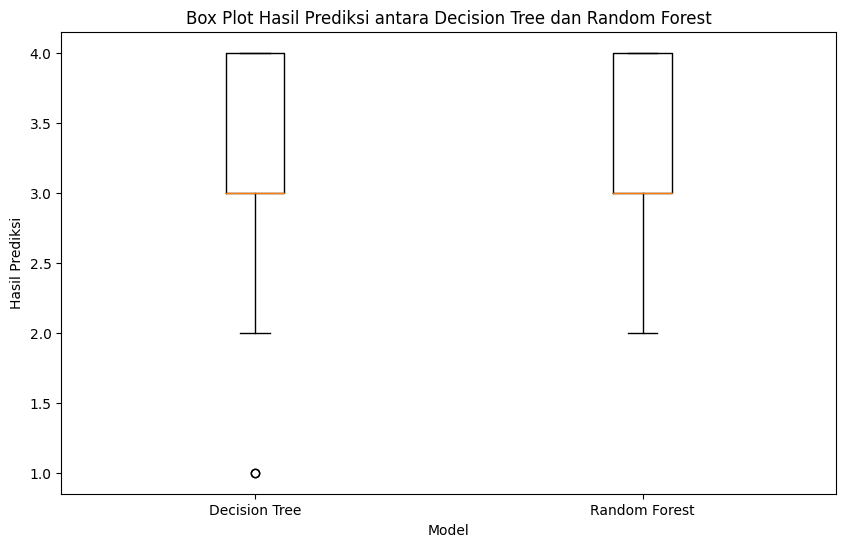

In [ ]:

# Hasil prediksi dari model Decision Tree
predictions_dt = model_dt.transform(test_data)
y_true_dt = predictions_dt.select("Stage").rdd.flatMap(lambda x: x).collect()
y_pred_dt = predictions_dt.select("prediction").rdd.flatMap(lambda x: x).collect()

# Hasil prediksi dari model Random Forest
predictions_rf = model_rf.transform(test_data)
y_true_rf = predictions_rf.select("Stage").rdd.flatMap(lambda x: x).collect()
y_pred_rf = predictions_rf.select("prediction").rdd.flatMap(lambda x: x).collect()

# Menampilkan box plot
plt.figure(figsize=(10, 6))
plt.boxplot([y_pred_dt, y_pred_rf], labels=["Decision Tree", "Random Forest"])
plt.title("Box Plot Hasil Prediksi antara Decision Tree dan Random Forest")
plt.xlabel("Model")
plt.ylabel("Hasil Prediksi")
plt.show()

## Prediksi dengan input baru

In [ ]:

input_data = {
    "Age": 21464, #days
    "Sex": 0, # 0 - male - 1 female
    "Ascites": 1, # 1 - yes 0 no
    "Hepatomegaly": 1,# 1 - yes 0 no
    'Spiders': 1,# 1 - yes 0 no
    "Bilirubin": 14.5,
    "Cholesterol":  261.0,
    "Albumin": 2.6,
    "Copper": 156.0,
    "Alk_Phos": 1718.0,
    "SGOT": 137.95,
    "Tryglicerides": 172.0,
    "Platelets": 190.0,
    "Prothrombin": 12.2
}
#features = ['Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

# Konversi data input menjadi Row
input_row = Row(**input_data)
# Buat DataFrame dari data input
input_df = spark.createDataFrame([input_row])

# Gunakan VectorAssembler untuk menggabungkan fitur ke dalam vektor
input_df = assembler.transform(input_df)

# Pilih kolom yang dibutuhkan
input_df = input_df.select("features")

# Lakukan prediksi dengan model Decision Tree
prediction = best_model_rf.transform(input_df)

# Tampilkan hasil prediksi
result = prediction.select("prediction").collect()[0].prediction
print(f"Hasil Prediksi: {result}")

Hasil Prediksi: 4.0


#Terimakasih
⣿⣇⣿⡿⠇⣾⣿⣿⣿⣿⡘⢸⣷⡙⢿⣇⠿⡛⣋⡵⠿⠛⠿⣷⣝⢸⣿⣿⣿⡘                                  
⣿⣿⢸⣿⢠⣶⣬⣭⣝⣛⣷⡀⣿⣿⣧⣝⠸⣿⡏⣴⣿⣿⣶⡈⢿⣸⣿⡿⣿⡇                                  
⣿⣿⡎⣿⢸⡿⣫⣥⣬⣙⢿⣿⣿⣿⣿⣿⣿⣿⡇⢿⣿⣿⣿⡇⢸⢿⣿⢧⣿⡇                                  
⣿⣿⣷⠁⣼⢠⣿⣿⣿⣿⡆⣿⣿⣿⣿⣿⣿⠿⣿⣬⣙⣛⣋⣴⣿⢸⢏⣾⣿⡇                                  
⣿⢿⣿⣧⢸⣄⠿⣿⣿⠿⢡⣿⣿⣿⣿⣿⣿⣿⠿⡿⣿⣿⣿⣿⡟⢈⢸⣿⣿⣯                                  
⡹⡠⡙⢿⣦⠻⣷⣶⣶⣾⣿⣿⣿⡿⢟⣭⣷⣾⣿⣿⠘⣿⣿⣿⣧⣾⢸⣿⣿⣿                                  
⣷⣄⡇⢶⣍⠳⠙⢿⣿⣿⣿⣿⣏⠀⣿⣿⣿⣿⣿⣿⠀⣿⣿⣧⣵⠋⢸⣿⣿⡿                                  
⣿⣿⣷⢸⣿⣆⢷⣦⣿⣿⣿⣿⣿⣆⠻⣿⣿⣿⣿⡟⣸⣿⣿⠟⠁⠀⢸⣿⣿⡇                                  
⣿⣿⣿⢸⣿⣿⣌⠻⣿⣿⣿⣿⣿⣿⣷⣮⣝⣛⣿⣴⡿⠋⢁⠀⠀⠀⢸⣿⣿⠇                                  
⣿⣿⢿⠸⣿⣿⣿⢸⣆⢭⡝⠛⠛⠛⠟⠟⠛⠛⠉⠁⢀⣴⣿⣆⠀⠀⣸⣿⣿                                  

